# Diffusing Neural Cellular Automata [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/43_diffusing_nca.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [7]:
import jax
import jax.numpy as jnp
import mediapy
import optax
import PIL
from flax import nnx
from tqdm.auto import tqdm

from cax.core.ca import CA
from cax.core.perceive import ConvPerceive, grad_kernel, identity_kernel
from cax.core.update import NCAUpdate
from cax.utils import clip_and_uint8, rgba_to_rgb
from cax.utils.emoji import get_emoji

## Configuration

In [8]:
seed = 0

channel_size = 64
num_kernels = 3
hidden_size = 256
cell_dropout_rate = 0.5

batch_size = 8
num_steps = 64
learning_rate = 1e-3

emoji = "🦎"
size = 40
pad_width = 16

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset

""

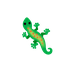

In [9]:
def get_y_from_emoji(emoji: str) -> jax.Array:
	"""Get target y from an emoji."""
	emoji_pil = get_emoji(emoji)
	emoji_pil = emoji_pil.resize((size, size), resample=PIL.Image.Resampling.LANCZOS)

	y = jnp.array(emoji_pil, dtype=jnp.float32) / 255.0
	y = jnp.pad(y, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)))

	return y


y = get_y_from_emoji(emoji)

mediapy.show_image(y)

## Model

In [ ]:
perceive = ConvPerceive(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	rngs=rngs,
	feature_group_count=channel_size,
)
update = NCAUpdate(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	hidden_layer_sizes=(hidden_size,),
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
	zeros_init=True,
)

In [10]:
class DiffusingNCA(CA):
	"""Diffusing Neural Cellular Automata."""

	def __init__(self, perceive, update):
		"""Initialize Diffusing NCA."""
		super().__init__(perceive, update)

		# Initialize kernel with sobel filters
		kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
		kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
		self.perceive.conv.kernel = nnx.Param(kernel)

	@nnx.jit
	def render(self, state):
		"""Render state to RGB."""
		rgba = state[..., -4:]
		rgb = rgba_to_rgb(rgba)

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgb)

	@nnx.jit
	def render_rgba(self, state):
		"""Render state to RGBA."""
		rgba = state[..., -4:]

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgba)

In [11]:
ca = DiffusingNCA(perceive, update)

In [12]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", sum(x.size for x in jax.tree.leaves(params)))

Number of params: 67584


## Sample initial state

In [13]:
def add_noise(image, alpha, key):
	"""Add noise to the image with a given alpha value."""
	noise = jax.random.normal(key, image.shape)
	noisy_image = (1 - alpha) * image + alpha * noise
	return jnp.clip(noisy_image, 0.0, 1.0)


def sample_state(key):
	"""Sample a state with added noise."""
	state = jnp.zeros(y.shape[:2] + (channel_size,))

	alpha_key, noise_key = jax.random.split(key)

	# Add noise
	alpha = jax.random.uniform(alpha_key)
	noisy_y = add_noise(y, alpha, noise_key)

	return state.at[..., -4:].set(noisy_y)

## Train

### Optimizer

In [15]:
lr_sched = optax.linear_schedule(
	init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000
)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [16]:
def mse(state):
	"""Mean Squared Error."""
	return jnp.mean(jnp.square(state[..., -4:] - y))

In [17]:
@nnx.jit
def loss_fn(ca, state):
	"""Loss function."""
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state, _ = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	loss = mse(state)
	return loss

### Train step

In [18]:
@nnx.jit
def train_step(ca, optimizer, key):
	"""Train step."""
	keys = jax.random.split(key, batch_size)
	current_state = jax.vmap(sample_state)(keys)

	loss, grad = nnx.value_and_grad(loss_fn, argnums=nnx.DiffState(0, update_params))(
		ca, current_state
	)
	optimizer.update(grad)

	return loss

### Main loop

In [ ]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []
for i in pbar:
	key, subkey = jax.random.split(key)
	loss = train_step(ca, optimizer, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.3e}"})

## Run

In [22]:
num_examples = 8

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_examples)
state_init = jax.vmap(sample_state)(keys)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state_final, states = nnx.split_rngs(splits=num_examples)(
	nnx.vmap(
		lambda ca, state: ca(state, num_steps=num_steps),
		in_axes=(state_axes, 0),
	)
)(ca, state_init)

## Visualize

,,,,,,,

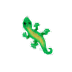
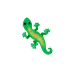
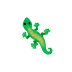
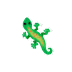
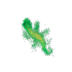
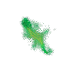
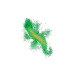
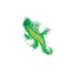

,,,,,,,

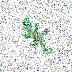
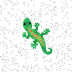
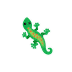
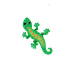
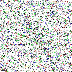
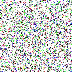
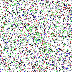
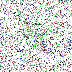

In [ ]:
frames = jax.vmap(ca.render)(states)
frames_final = jax.vmap(ca.render)(state_final)
frames_final_rgba = jax.vmap(ca.render_rgba)(state_final)

mediapy.show_images(frames_final, width=128, height=128)
mediapy.show_videos(frames, width=128, height=128, codec="gif")